# (not done) Node Classification with Graph Neural Networks
> 공부

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [GNN]

ref: https://keras.io/examples/graph/gnn_citations/

- GNN의 간단한 구현 예제
- 그래프 컨볼루션 레이어 구현

사용한 cora dataset

https://relational.fit.cvut.cz/dataset/CORA

---

논문: 2708개
- 7개의 class
    - 'Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory'
    
인용: 5429개

단어: 1433개

---

CORA 데이터 이해

- The goal of our experiments is to predict the categories assigned to each paper.
    - 각 논문에 할당된 카테고리를 예측하는 게 시험의 목표이다.
- Dataset has been pre-processed removing papers that don't belong to at least one category. Also paper that don't have authors and don't have a title have been discarded. 
    - 하나의 카테고리에도 속하지 않은 논문들은 사전에 제거되었다. 저자가 없거나 제목 없는 논문들도 제거되었다.
        - 즉, 결측값은 없다는 뜻
- 11881 papers belonging to 80 different categories
    - 80개의 다른 카테고리를 가진 11,881개의 논문
- 16114 authors
    - 16,114명의 저자
- 34648 citations relations between papers
    - 논문 사이에 인용관계 24,648
- 27020 authorship relations between papers and authors
    - 논문과 저자 사이의 저작권 관계 27,020
- Each paper is associated with a vectorial representation containing its title represented as bag-of-words with TF-IDF weights.
    - 각 논문은 벡터 표현되어 있다.
- 목표
    - link-prediction problem: predict citation relations between papers or authorship relations with authors
        - 연결 예측 문제: 논문 간의 인용관계 예측 또는 저자 간의 저작권 관계 예측
    - multi-label classification problem: predict the categories assigned to each  paper
        - 다중 레이블 분류 문제: 각 논문에 관련된 카테고리 예측

![](https://relational.fit.cvut.cz/assets/img/datasets-generated/CORA.svg)

- The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.
    - Cora는 7개의 class에서 분류된 2,708개의 과학 출판물로 구성되어 있다. 이 인용 network는 5,429개의 연결로 구성되어 있고, 각 출판물은 사전에서 부합하는 단어의 존재와 부재를 나타내는 valued 단어 벡터로 0/1로써 나타난다. 사전은 1,433개의 unique 단어들로 구성되어 있다.
    
- The Cora dataset consists of 2,708 scientific papers classified into one of seven classes. The citation network consists of 5,429 links. Each paper has a binary word vector of size 1,433, indicating the presence of a corresponding word.

---

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-05-28 15:30:57.462261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-28 15:30:57.462288: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Prepare the Dataset

The dataset has two tap-separated files: cora.cites and cora.content.
- cora.cites와 cora.content의 tab으로 구분된 파일들이다.

The cora.cites includes the citation records with two columns: cited_paper_id (target) and citing_paper_id (source).
- cora.cites는 cited_paper_id (target)와 citing_paper_id (source)의 두 개의 열이 있는 인용 레코드가 포함된다.

The cora.content includes the paper content records with 1,435 columns: paper_id, subject, and 1,433 binary features.
- cora.content는 paper_id, subject, 1,433 binary features이 1,435개의 열이 포함된 논문 내용 기록이 포함된다.

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [3]:
data_dir

'/home/csy/.keras/datasets/cora'

In [4]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [5]:
citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  5429 non-null   int64
 1   source  5429 non-null   int64
dtypes: int64(2)
memory usage: 85.0 KB


The target column includes the paper ids cited by the paper ids in the source column.
- source 열에 있는 논문 id에 의해 인용된 논문 id를 target 열이 포함한다.

In [6]:
citations.sample(frac=1).head()

,target,source
3274,52515,39199
1406,6782,1123068
3541,67584,562067
2994,38845,1107010
2584,28249,1116347


In [7]:
citations

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [63]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [64]:
len(papers['subject'])

2708

In [65]:
len(papers.groupby('subject'))

7

In [66]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [98]:
papers.groupby('subject').count().reset_index().iloc[:,0].tolist()

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

Now we display a sample of the papers DataFrame. The DataFrame includes the paper_id and the subject columns, as well as 1,433 binary column representing whether a term exists in the paper or not.
- 이 데이터에는 논문에 단어가 있는지 없는 지를 나타내는 1,433개의 이진 열과 논문id와 제목 열을 포함한다. 

dataset.saple(n): 데이터에서 랜덤으로 n개를 뽑는다.

In [10]:
papers.sample(5)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
606,1133196,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
755,1129629,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Genetic_Algorithms
549,12210,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
106,37998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rule_Learning
1143,650834,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Genetic_Algorithms


In [11]:
print(papers.sample(5).T)

             1708           2213             1431    382            1301
paper_id   509233        1127851            34708   44017         137380
term_0          0              0                0       0              0
term_1          0              0                0       0              0
term_2          0              0                0       0              0
term_3          0              0                0       0              0
...           ...            ...              ...     ...            ...
term_1429       0              0                0       0              0
term_1430       0              0                0       0              0
term_1431       0              0                0       0              0
term_1432       0              0                0       0              0
subject    Theory  Rule_Learning  Neural_Networks  Theory  Rule_Learning

[1435 rows x 5 columns]


the count of the papers in each subject.

In [12]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


We convert the paper ids and the subjects into zero-based indices.
- 논문 id와 subject를 0 기반의 표현으로 변환한다.

In [13]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [14]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,2370,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2704,2371,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2705,2372,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2706,955,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---

In [15]:
papers["subject"].unique()

array([2, 5, 4, 3, 6, 1, 0])

데이터 셋 내의 유일한 값을 찾고 싶을 때 사용하는 `unique()` 고유한 값이 출력된다.

---

In [16]:
# example of enumerate() 열반복 시행
df = pd.DataFrame([[10,6,7,8],
                   [1,9,12,14],
                   [5,8,10,6]],
                  columns = ['a','b','c','d'])

for (index, colname) in enumerate(df):
    print(index, df[colname].values)

0 [10  1  5]
1 [6 9 8]
2 [ 7 12 10]
3 [ 8 14  6]


---

In [17]:
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [18]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

`isin`메서드는 DataFrame객체의 각 요소가 values값과 일치하는지 여부를 bool형식으로 반환합니다.

Now let's visualize the citation graph. Each node in the graph represents a paper, and the color of the node corresponds to its subject. Note that we only show a sample of the papers in the dataset.
- 그래프의 각 노드는 논문을 의미하고, 노드의 색은 subject를 나타낸다. 여기서 보이는것은 데이터의 sample이다.

In [100]:
citations

,target,source
0,0,21
1,0,905
2,0,906
3,0,1909
4,0,1940
...,...,...
5424,1873,328
5425,1873,1876
5426,1874,2586
5427,1876,1874


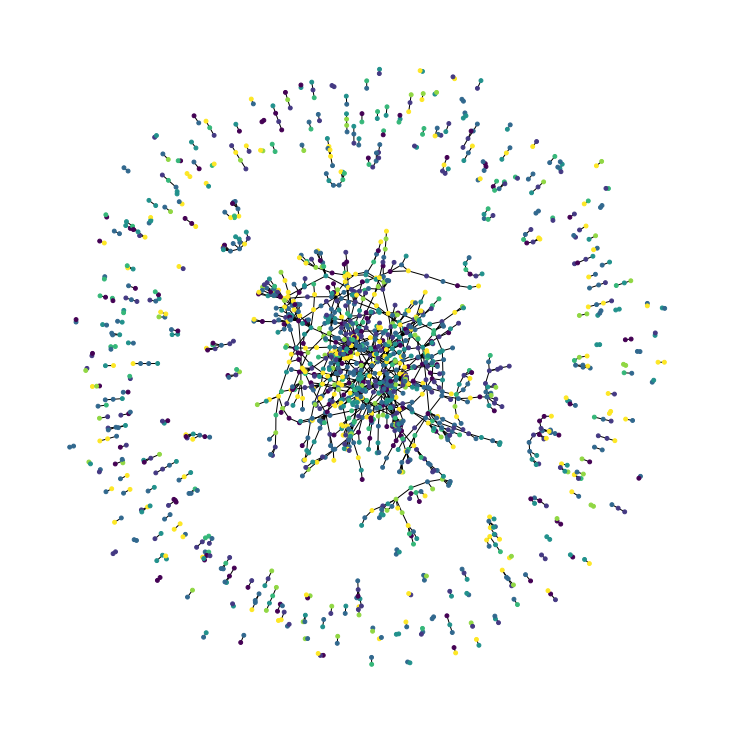

In [19]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Split the dataset into stratified train and test sets
- 데이터를 계츤화된 체스트와 train셋으로 나누기

DataFrame으로 부터 특정 비율의 표본을 무작위로 추출하기 (fraction) `df.sample(frac=0.5)`
- DataFrame으로 부터 특정 비율(fraction)으로 무작위 표본 추출을 하고 싶으면 frac 매개변수에 0~1 사이의 부동소수형(float) 값을 입력

In [20]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1339, 1435)
Test data shape: (1369, 1435)


### Implement Train and Evaluate Experiment
- train 으로 시험해서 test 평가

In [21]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

This function compiles and trains an input model using the given training data.
- 주어진 training data로 입력 모델 컴파일 및 train하는 함수

- Adam 사용
- 학습률은 0.01
- 손실함수(`losses.SparseCategoricalCrossentropy()`) (https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
    - Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss. There should be # classes floating point values per feature for y_pred and a single floating point value per feature for y_true.
    - 두 개 이상의 레이블 클래스가 있는 경우 이 crossentropy loss function을 사용한다. 레이블은 정수로 제공될 것으로 기대힌다. one-hot representation을 사용하여 레이블을 나타내려면 CategoricalCrossentropy loss를 사용한다. # classes에 대한 기능당 부동 소수점 값 y_pred 과 y_true에 대한 기능당 단일 부동 소수점 값이 있어야 한다.
    - `from_logits`
        - Whether y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.
        - y_pred가 logits tensor로 예상되는지의 여부다. 기본설정은 y_pred가 확률분포라고 (from_logit=False) 되어 있다.
    - Both, categorical cross entropy and sparse categorical cross entropy have the same loss function which you have mentioned above. The only difference is the format in which you mention $Y_i$ (i,e true labels).(https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other)
        - If your $Y_i$'s are one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): $[1,0,0] , [0,1,0], [0,0,1]$
        - But if your $Y_i$'s are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: $[1] , [2], [3]$
- metric(`tf.keras.metrics.SparseCategoricalAccuracy()`)
    - tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)
        - name $\to$ (Optional) string name of the metric instance.

- callback(`keras.callbacks.EarlyStopping()`) (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) (Stop training when a monitored metric has stopped improving. 모니터된 metric이 improve를 멈출때 훈련이 중지된다.)
    - tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=0,mode='auto',baseline=None,restore_best_weights=False)
        - monitor	Quantity to be monitored.
        - patience	Number of epochs with no improvement after which training will be stopped.
        - restore_best_weights	Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.
            - 가중치를 재복원할 것인지의 여부를 뭍는다. False라면 훈련의 마지막 단계에서 얻은 모델 가중치를 얻게 된다. 기저치와 관련있어서 baseline에서 에폭 변화가 없으면 그 상태에서 best 에폭으로부터 가중치를 재복원하는 것 같은..

In [22]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

This function displays the loss and accuracy curves of the model during training.
- 훈련하는 동안 손실과 정확도 곡선을 나타내는 함수

In [23]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

### Implement Feedforward Network (FFN) Module
- 순방향 신경망 구현

- 활성화함수(`tf.nn.gelu`) (https://www.tensorflow.org/api_docs/python/tf/nn/gelu) (Gaussian Error Linear Unit (GELU) activation function.)
    - tf.nn.gelu(features, approximate=False, name=None)
    - Gaussian error linear unit (GELU) computes $x * P(X <= x)$, where $P(X) \sim N(0, 1)$. The (GELU) nonlinearity weights inputs by their value, rather than gates inputs by their sign as in ReLU.
        - GELU 가우시안 에러 선형 단위(?), Relu 함수는 부호에 따라 입력함수를 처리해주었다면, Gelu 함수는 값에 따라 입력함수를 처리한다. x $\times$ (x의 확률이 표준정규분포를 따를때 표준정규분포표에서 x 보다 작을 확률)

In [24]:
x=tf.constant(np.linspace(-10,10,100))

In [25]:
y=tf.nn.gelu(x)

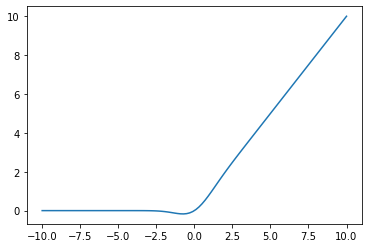

In [26]:
plt.plot(x,y)

In [27]:
tf.nn.gelu?

Signature: tf.nn.gelu(features, approximate=False, name=None)
Docstring:
Compute the Gaussian Error Linear Unit (GELU) activation function.

Gaussian error linear unit (GELU) computes
`x * P(X <= x)`, where `P(X) ~ N(0, 1)`.
The (GELU) nonlinearity weights inputs by their value, rather than gates
inputs by their sign as in ReLU.

For example:

>>> x = tf.constant([-3.0, -1.0, 0.0, 1.0, 3.0], dtype=tf.float32)
>>> y = tf.nn.gelu(x)
>>> y.numpy()
array([-0.00404951, -0.15865529,  0.        ,  0.8413447 ,  2.9959507 ],
    dtype=float32)
>>> y = tf.nn.gelu(x, approximate=True)
>>> y.numpy()
array([-0.00363752, -0.15880796,  0.        ,  0.841192  ,  2.9963627 ],
    dtype=float32)

Args:
  features: A `Tensor` representing preactivation values.
  approximate: An optional `bool`. Defaults to `False`. Whether to enable
    approximation.
  name: A name for the operation (optional).

Returns:
  A `Tensor` with the same type as `features`.

References:
  [Gaussian Error Linear Units (GELUs)](

In [28]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

### Build a Baseline Neural Network Model

In [29]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [104]:
train_data['subject']

462     2
169     2
2516    1
2691    2
1529    4
       ..
2616    0
302     5
1190    2
1855    0
1462    2
Name: subject, Length: 1339, dtype: int64

Implement a baseline classifier
- We add five FFN blocks with skip connections, so that we generate a baseline model with roughly the same number of parameters as the GNN models to be built later.
- skip connection을 가진 FFN 블록을 5개 추가해서 나중에 GNN 모델 만들때 파라미터의 수를 대략적으로 기준 모델과 같게 하도록 한다.

---

이게 뭘까..

In [30]:
f"ffn_block1"

'ffn_block1'

앞에 f붙이면 문자열로 인식 https://docs.python.org/3/reference/lexical_analysis.html#f-strings

---

위에서 hidden_units은 [32,32]로, num_class는 class index 수로 정의

In [31]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [146]:
x_train

array([ 855, 1335, 1324, ..., 2011,   98,  461])

In [147]:
y_train

462     2
169     2
2516    1
2691    2
1529    4
       ..
2616    0
302     5
1190    2
1855    0
1462    2
Name: subject, Length: 1339, dtype: int64

In [32]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 2s 81ms/step - loss: 3.3838 - acc: 0.1591 - val_loss: 1.8293 - val_acc: 0.3333
Epoch 2/300
5/5 [==============================] - 0s 23ms/step - loss: 2.8493 - acc: 0.2487 - val_loss: 1.8352 - val_acc: 0.3582
Epoch 3/300
5/5 [==============================] - 0s 23ms/step - loss: 2.3855 - acc: 0.2381 - val_loss: 1.8452 - val_acc: 0.3582
Epoch 4/300
5/5 [==============================] - 0s 25ms/step - loss: 2.1194 - acc: 0.2575 - val_loss: 1.8508 - val_acc: 0.3582
Epoch 5/300
5/5 [==============================] - 0s 25ms/step - loss: 2.0218 - acc: 0.2970 - val_loss: 1.8406 - val_acc: 0.3433
Epoch 6/300
5/5 [==============================] - 0s 27ms/step - loss: 1.8969 - acc: 0.3137 - val_loss: 1.8392 - val_acc: 0.3532
Epoch 7/300
5/5 [==============================] - 0s 30ms/step - loss: 1.7959 - acc: 0.3137 - val_loss: 1.8343 - val_acc: 0.3731
Epoch 8/300
5/5 [==============================] - 0s 29ms/step - loss: 1.7458 - acc: 0.35

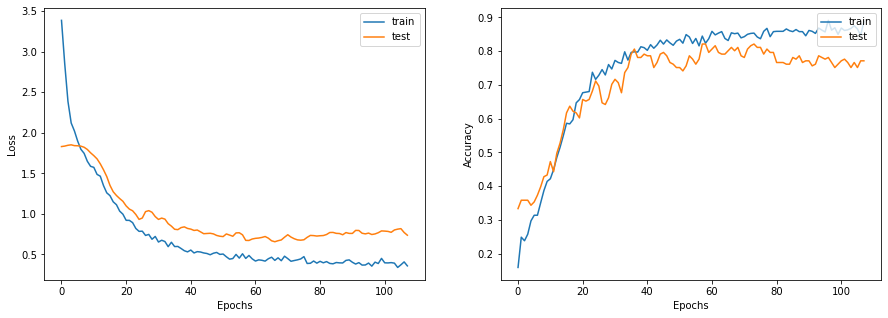

In [33]:
display_learning_curves(history)

test로 평가

In [34]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 75.38%


### Examine the baseline model predictions

Let's create new data instances by randomly generating binary word vectors with respect to the word presence probabilities.
- 단어가 존재하는 확률과 관련해서 이진 단어 벡터를 무작위로 만드는 새로운 데이터 인스턴스를 생성

In [35]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

- `tf.convert_to_tensor(logits)` logit을 텐서로 변환

In [36]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 1.16%
- Genetic_Algorithms: 1.02%
- Neural_Networks: 37.81%
- Probabilistic_Methods: 5.56%
- Reinforcement_Learning: 0.35%
- Rule_Learning: 1.69%
- Theory: 52.42%
Instance 2:
- Case_Based: 1.83%
- Genetic_Algorithms: 9.77%
- Neural_Networks: 64.92%
- Probabilistic_Methods: 12.92%
- Reinforcement_Learning: 4.37%
- Rule_Learning: 0.74%
- Theory: 5.45%
Instance 3:
- Case_Based: 4.83%
- Genetic_Algorithms: 2.85%
- Neural_Networks: 53.39%
- Probabilistic_Methods: 6.96%
- Reinforcement_Learning: 1.06%
- Rule_Learning: 0.85%
- Theory: 30.05%
Instance 4:
- Case_Based: 0.5%
- Genetic_Algorithms: 58.36%
- Neural_Networks: 33.56%
- Probabilistic_Methods: 4.26%
- Reinforcement_Learning: 0.47%
- Rule_Learning: 0.89%
- Theory: 1.96%
Instance 5:
- Case_Based: 36.71%
- Genetic_Algorithms: 2.45%
- Neural_Networks: 18.55%
- Probabilistic_Methods: 3.56%
- Reinforcement_Learning: 0.75%
- Rule_Learning: 26.78%
- Theory: 11.19%
Instance 6:
- Case_Based: 1.27%
- Genetic_Algorithms: 

### Build a Graph Neural Network Model

The graph data is represented by the graph_info tuple, which consists of the following three elements:

1. node_features: This is a [num_nodes, num_features] NumPy array that includes the node features. In this dataset, the nodes are the papers, and the node_features are the word-presence binary vectors of each paper.
    - 노드 특징을 포함하는 넘파이 배열이다.노드는 papers이고, node_features는 각 논문 사이의 단어 존재 이진 벡터이다.
2. edges: This is [num_edges, num_edges] NumPy array representing a sparse adjacency matrix of the links between the nodes. In this example, the links are the citations between the papers.
    - 노드 사이의 연결의 희소 인접 행렬을 나타내는 넘파이 배열이다. 이 예제에서 link는 paper 사이의 인용이다.
3. edge_weights (optional): This is a [num_edges] NumPy array that includes the edge weights, which quantify the relationships between nodes in the graph. In this example, there are no weights for the paper citations.
    - 그래프에서 노드 사이 관계를 정량화하는 엣지 가중치를 포함하는 넘파이 배열이다. 이 예제에서 논문 잉용에 대한 가중치는 없다.

In [112]:
graph_info

(<tf.Tensor: shape=(2708, 1433), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 array([[  21,  905,  906, ..., 2586, 1874, 2707],
        [   0,    0,    0, ..., 1874, 1876, 1897]]),
 <tf.Tensor: shape=(5429,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>)

**sparse adjacency matrix**
- 노드 수보다 엣지 수가 적은 matrix

In [150]:
edges.shape

(2, 5429)

In [37]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### Implement a graph convolution layer

gru? 가 뭘까..

We implement a graph convolution module as a Keras Layer. Our GraphConvLayer performs the following steps:

1. Prepare: The input node representations are processed using a FFN to produce a message. You can simplify the processing by only applying linear transformation to the representations.
    - 입력 노드 표현은 메세지를 제공하는 FFN을 사용하여 처리된다. 그 표현을 오직 선형 변환만 적용함으로써 처리를 단순화할 수 있다.
2. Aggregate: The messages of the neighbours of each node are aggregated with respect to the edge_weights using a permutation invariant pooling operation, such as sum, mean, and max, to prepare a single aggregated message for each node. See, for example, tf.math.unsorted_segment_sum APIs used to aggregate neighbour messages.
    - 각 노드들의 이웃들의 메세지는 각 노드에 대해 단순 집계된 메세지를 준비하기 위해서 sum, mean, max 같은 순열 불변 풀링 operation을 사용한 edge_weights를 나타내어 집계한다. 예를들어, tf.math.unsorted_usum API는 이웃 메세지들을 집계하는데 사용된다.
3. Update: The node_repesentations and aggregated_messages—both of shape [num_nodes, representation_dim]— are combined and processed to produce the new state of the node representations (node embeddings). If combination_type is gru, the node_repesentations and aggregated_messages are stacked to create a sequence, then processed by a GRU layer. Otherwise, the node_repesentations and aggregated_messages are added or concatenated, then processed using a FFN.
    - node_repesentations 과 aggregated_messages—both는 노드 표현(노드 임베딩)의 새로운 상태를 제공하기 위해 결합되고 처리된다. 만일 conbination type이 gru라면, node_repesentations and aggregated_messages는 시퀀스를 만들기 위해 쌓이게 되면 GPU 층에 의해 처리된다. 반면에 node_repesentations and aggregated_messages가 추가되거나 연결되면 FFN을 사용하여 처리된다.

---

GRU; Gated Recurrent Unit 게이트 순환 유닛(https://keras.io/api/layers/recurrent_layers/gru/)
- LSTM에서의 장기 의존성 문제의 해결책은 유지하면서 은닉 상태 업데이트 계산을 줄임
    - 학습 속도는 빠르지만 비슷한 성능을 보인다.
- 3개의 게이트(출력, 입력, 삭제)가 존재하는 LSTM
- 2개의 게이트(업데이트, 리셋)만 존재하는 GRU

---

`*arg`
- argument. 인자로 받음.
- 함수 내에 몇 개의 인자로 받을지 확실하지 않을때 사용

`**karg`
- keyword argument, dictionary형테 {'keyword': value}로 함수 내부에 전달

$\star$순서
```python
def f(일반변수, *arg, **karg):
...
```

---

`super(other class,self).__init__()`
- other class를 상속받는 방법

---

Hyperbolic Tangent = Hyperbolic Sine / Hyperbolic Cosine
$$\tanh z = \frac{\sinh z}{\cosh z} = \frac{e^z - e^{-z}}{e^z + e^{-z}} = \frac{e^{2z} -1}{e^{2z} + 1}$$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Sinh_cosh_tanh.svg/256px-Sinh_cosh_tanh.svg.png)

---

`tf.expand_dims(,axis=)` (https://www.tensorflow.org/api_docs/python/tf/expand_dims)
- 배열의 차원을 늘려준다.
- axis는 몇 번째 차원을 늘릴 것인지.

---

`tf.math.unsorted_segment_max` (https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_max)
- 세그먼트들의 최대값을 계산해낸다.

`tf.math.unsorted_segment_mean`
- 세그먼트들의 평균을 계산해낸다.

`tf.math.unsorted_segment_sum`
- 세그먼트들의 합을 계산해낸다.

---

In [38]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, aggregated_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

The GNN classification model follows the Design Space for Graph Neural Networks approach, as follows:

1. Apply preprocessing using FFN to the node features to generate initial node representations.
    - 초기 노드 표현을 일반화하기 위해 노드 특징들을 FFN을 사용하여 준비한다.
2. Apply one or more graph convolutional layer, with skip connections, to the node representation to produce node embeddings.
    - slip connection을 가진 하나 이상의 그래프 컴볼루션 레이어를 노드 표현에 적용하여 노드 임베딩을 만든다.
3. Apply post-processing using FFN to the node embeddings to generat the final node embeddings.
    - FFN 사용 후 마지막 노드 임베딩을 만들기 위한 노드 임베딩의 적용
4. Feed the node embeddings in a Softmax layer to predict the node class.
    - softmax 레이어의 노드 임베딩을 feed해 노드 클래스 예측

Each graph convolutional layer added captures information from a further level of neighbours. However, adding many graph convolutional layer can cause oversmoothing, where the model produces similar embeddings for all the nodes.
- 각 그래프 컨볼루션 레이어는 더 높은 수준의 이웃으로부터 정보를 capture한다. 하지만 그래프 컨볼루션 레이어를 많이 추가하는 것은 모델이 모든 노드에 대해 유사한 임베딩을 생성하는 oversmoothing을 야기할 수 있다. 

Note that the graph_info passed to the constructor of the Keras model, and used as a property of the Keras model object, rather than input data for training or prediction. The model will accept a batch of node_indices, which are used to lookup the node features and neighbours from the graph_info.
- graph_info는 케라스 모델의 condtructor에게 전달되며, 훈련이나 예측을 위한 입력 데이터보다는 케라스모델 개체의 속성으로 사용된다. 모델은 graph_info에서 노드 특징과 이웃을 lookup하는데 사용되는 node_indices의 배치를 수용한다.

In [123]:
np.where(edge_weights!=1)

(array([], dtype=int64),)

In [39]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [144]:
create_ffn(hidden_units, dropout_rate, name="postprocess")(node_features)

<tf.Tensor: shape=(2708, 32), dtype=float32, numpy=
array([[-0.0438415 ,  0.05822259,  0.01784638, ...,  0.01314815,
        -0.00288184, -0.00842262],
       [ 0.02056418,  0.04523989, -0.05037253, ...,  0.0137684 ,
         0.05119981, -0.0328092 ],
       [ 0.02786589, -0.02156354,  0.01393338, ...,  0.01485734,
         0.0336243 ,  0.01253645],
       ...,
       [-0.00390293,  0.02580145, -0.05101755, ...,  0.07115817,
         0.03063959, -0.04158287],
       [-0.02493567, -0.00982335, -0.05645709, ...,  0.08836337,
         0.0315274 , -0.00958259],
       [-0.03271731, -0.02948607, -0.03748903, ..., -0.01709204,
        -0.02062779,  0.01670217]], dtype=float32)>

---

In [124]:
params = tf.constant(['p0', 'p1', 'p2', 'p3', 'p4', 'p5'])

In [131]:
type(params)

tensorflow.python.framework.ops.EagerTensor

In [125]:
params[3].numpy()

b'p3'

In [126]:
tf.gather(params, 3).numpy()

b'p3'

---

### Train the GNN model

Let's test instantiating and calling the GNN model. Notice that if you provide N node indices, the output will be a tensor of shape [N, num_classes], regardless of the size of the graph.
- GNN 모델을 인스턴스화하고 호출하는 것을 테스트한다. N개의 node indices를 주면 결과는 그래프의 크기에 관계없이 n by class수 모양의 tensor가 될 것이다.

In [40]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.02350981 -0.14313753 -0.07081249 -0.11289644  0.14993845  0.0873058
  -0.01819227]
 [-0.04401194  0.10897765 -0.00774123  0.0819732   0.01297503  0.0841588
   0.08213045]
 [-0.01202856  0.14770731 -0.08484578 -0.02777675  0.05898174  0.10339345
   0.03408212]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                              

Note that we use the standard supervised cross-entropy loss to train the model. However, we can add another self-supervised loss term for the generated node embeddings that makes sure that neighbouring nodes in graph have similar representations, while faraway nodes have dissimilar representations.
- 모델 학습을 위해 cross-entropy loss 이용. 하지만 생성된 node embedding에 대해 또다른 자체 supervised loss term을 추가할 수 있다. 여기서 멀리 있는 노드들은 서로다른 표현을 가지는동안 그래프에 이웃한 노드들은 유사한 표현을 가지고 있다.

임베딩하는 함수가 representation이라고 보면 될듯

In [41]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 3s 139ms/step - loss: 2.2355 - acc: 0.1854 - val_loss: 1.8983 - val_acc: 0.3333
Epoch 2/300
5/5 [==============================] - 0s 68ms/step - loss: 2.0095 - acc: 0.2557 - val_loss: 1.8857 - val_acc: 0.3383
Epoch 3/300
5/5 [==============================] - 0s 70ms/step - loss: 1.9142 - acc: 0.2627 - val_loss: 1.8813 - val_acc: 0.3383
Epoch 4/300
5/5 [==============================] - 0s 73ms/step - loss: 1.8759 - acc: 0.2715 - val_loss: 1.8771 - val_acc: 0.3383
Epoch 5/300
5/5 [==============================] - 0s 74ms/step - loss: 1.8869 - acc: 0.2680 - val_loss: 1.8708 - val_acc: 0.3731
Epoch 6/300
5/5 [==============================] - 0s 70ms/step - loss: 1.8471 - acc: 0.2856 - val_loss: 1.8615 - val_acc: 0.3682
Epoch 7/300
5/5 [==============================] - 0s 71ms/step - loss: 1.8296 - acc: 0.2961 - val_loss: 1.8465 - val_acc: 0.3682
Epoch 8/300
5/5 [==============================] - 0s 71ms/step - loss: 1.8378 - acc: 0.2

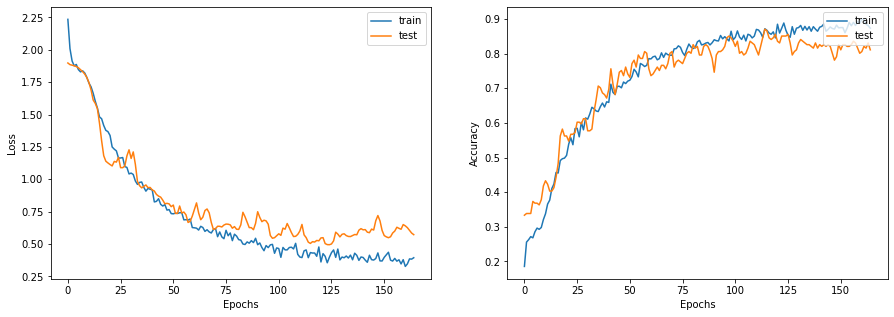

In [42]:
display_learning_curves(history)

Now we evaluate the GNN model on the test data split. The results may vary depending on the training sample, however the GNN model always outperforms the baseline model in terms of the test accuracy.
- 분할한 test 데이터에 GNN모델 평가. 결과는 훈련 샘플에 따라 달라질 수 있지만 GNN 모델은 항상 테스트 정확도의 면에서 기준모델을 능가한다.

In [43]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 82.25%


Examine the GNN model predictions

Let's add the new instances as nodes to the node_features, and generate links (citations) to existing nodes.
- node_feature에 새로운 인스턴스 추가하고 기존노드에 인용연결 생성

In [44]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)


Now let's update the node_features and the edges in the GNN model.

In [45]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 52.17%
- Genetic_Algorithms: 0.75%
- Neural_Networks: 9.41%
- Probabilistic_Methods: 17.1%
- Reinforcement_Learning: 0.57%
- Rule_Learning: 6.21%
- Theory: 13.8%
Instance 2:
- Case_Based: 0.37%
- Genetic_Algorithms: 90.15%
- Neural_Networks: 2.64%
- Probabilistic_Methods: 0.12%
- Reinforcement_Learning: 6.43%
- Rule_Learning: 0.17%
- Theory: 0.11%
Instance 3:
- Case_Based: 0.16%
- Genetic_Algorithms: 0.27%
- Neural_Networks: 97.32%
- Probabilistic_Methods: 1.05%
- Reinforcement_Learning: 0.27%
- Rule_Learning: 0.09%
- Theory: 0.83%
Instance 4:
- Case_Based: 1.08%
- Genetic_Algorithms: 0.27%
- Neural_Networks: 18.55%
- Probabilistic_Methods: 78.54%
- Reinforcement_Learning: 0.34%
- Rule_Learning: 0.19%
- Theory: 1.03%
Instance 5:
- Case_Based: 9.18%
- Genetic_Algorithms: 56.73%
- Neural_Networks: 5.29%
- Probabilistic_Metho